# Imports

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Reading the file

In [12]:
df=pd.read_csv('hotel.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,home_country,family_size
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,...,0,0,C,No Deposit,Transient,0.0,0,0,1,2.0
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,...,0,0,C,No Deposit,Transient,0.0,0,0,1,2.0
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,...,0,0,A,No Deposit,Transient,75.0,0,0,0,1.0
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,...,0,0,A,No Deposit,Transient,75.0,0,0,0,1.0
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,...,0,0,A,No Deposit,Transient,98.0,0,1,0,2.0


## What will we cover in this notebook ?
- categorical variables into dummy variables
- train test split
- random forest
- xgboost classifier
- hyperparameters tuning
- make predictions
- stacking

### Transforming the categorical variables into dummy variables

In [13]:
#We will label encode the feature arrival date month since it has a high cardinality.
le=LabelEncoder()
df.arrival_date_month=le.fit_transform(df['arrival_date_month'])

In [14]:
#creating dummy variables
df=pd.get_dummies(df)

In [15]:
df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,5,27,1,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,737,5,27,1,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,7,5,27,1,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,13,5,27,1,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,5,27,1,0,2,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0


### train test split

In [16]:
#Splitting the depedent and the independent variables
X=df.drop('is_canceled',axis=1)
y=df.is_canceled

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### First let's find out what metrics will we use for our classification problem

In this classification task, we want to reduce the number of false negative, that is to say the number of bookings that we will predict canceled but that will not be. It is also important to reduce the number of false positive, but focusing on false negative is more important since if the hotel choose to allocate another booking to the room, it will be a problem if the first person that have booked the room come (2 families for only one room). It may be expensive for the hotel to deal with it.


#### Therefore, we will use recall, which is a good metric when we want to focus on reducing the number of false negative.

### Without any hyperparameter tuning

In [29]:
#Logistic Regression without any hyperparameter tuning
lr=LogisticRegression(max_iter=3000)
lr.fit(X_train,y_train)
preds_lr=lr.predict(X_test)

In [21]:
#random forest without any hyperparameter tuning
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
preds_rf=rf.predict(X_test)

In [22]:
#Gradient Boosting without any hyperparameter tuning
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
preds_xgb=xgb.predict(X_test)

In [30]:
print(f'Recall for the Logistic Regression:{recall_score(y_test,preds_lr)}')
print('\n')
print(f'Recall for the Random Forest Classifier:{recall_score(y_test,preds_rf)}')
print('\n')
print(f'Recall for the Extreme Gradient Boosting classifier:{recall_score(y_test,preds_xgb)}')

Recall for the Logistic Regression:0.6128156803618545


Recall for the Random Forest Classifier:0.7891443648699585


Recall for the Extreme Gradient Boosting classifier:0.7705239351677347


### Using Hyperparameter tuning

In [31]:
# Logistic regression

parameters = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

gs_lr=GridSearchCV(lr,parameters,scoring='recall',n_jobs=-1,cv=3)
gs_lr.fit(X_train,y_train)
gs_lr.best_estimator_

LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
lr=LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(X_train,y_train)

LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Random Forest

parameters={'n_estimators':(100,200,300,400),
           'max_features':['log2','sqrt',1,0.5],
           'min_samples_split':[2,3],
           'min_samples_leaf':[1,3,5,10,25]}

gs_rf=RandomizedSearchCV(rf,parameters,scoring='recall',n_jobs=-1,n_iter=10,cv=3)
gs_rf.fit(X_train,y_train)
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
# XGBoost Classifier

parameters={ "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

gs_xg=RandomizedSearchCV(xgb,parameters,scoring='recall',n_jobs=-1,n_iter=10,cv=3)
gs_xg.fit(X_train,y_train)
gs_xg.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
xg=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Make predictions

In [39]:
#Make predictions
preds_lr=lr.predict(X_test)
preds_rf=rf.predict(X_test)
preds_xg=xg.predict(X_test)

In [40]:
#Calculate the score of each model
scores_lr=recall_score(preds_lr,y_test)
scores_rf=recall_score(preds_rf,y_test)
scores_xg=recall_score(preds_xg,y_test)

In [41]:
#put the scores in a DataFrame
scores=pd.DataFrame({'scores':[scores_lr,scores_rf,scores_xg]})
scores= scores.rename(index={0:'Logistic_Reg',1:'Random_Forest',2:'XGBoost'}).sort_values('scores',ascending=False)
scores

,scores
Random_Forest,0.860628
XGBoost,0.857684
Logistic_Reg,0.806461


## Stacking

In [42]:
voting_clf_hard = VotingClassifier(estimators = [('Logistic_Reg',lr),('rf',rf),('XGBoost',xg)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('Logistic_Reg',lr),('rf',rf),('XGBoost',xg)], voting = 'soft') 

In [43]:
voting_clf_hard.fit(X_train,y_train)
preds_voting_hard=voting_clf_hard.predict(X_test)
scores_voting_hard=recall_score(preds_voting_hard,y_test)

In [44]:
#Hyperparameter tuning for the voting classifier.
#in a soft voting classifier you can weight some models more than others.

parameters = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

gs_voting=GridSearchCV(voting_clf_soft,parameters,scoring='recall',n_jobs=-1,cv=3)
gs_voting.fit(X_train,y_train)
gs_voting.best_estimator_

VotingClassifier(estimators=[('Logistic_Reg',
                              LogisticRegression(C=11.288378916846883,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=2000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_...
                                            m

In [45]:
#Make predictions
voting_clf_soft = VotingClassifier(estimators = [('Logistic_Reg',lr),('rf',rf),('XGBoost',xg)], voting = 'soft',weights=[1, 2, 2]) 
voting_clf_soft.fit(X_train,y_train)
preds_voting_soft=voting_clf_soft.predict(X_test)
scores_voting_soft=recall_score(preds_voting_soft,y_test)

In [46]:
# Scoring with accuracy
scores_lr_acc=accuracy_score(preds_lr,y_test)
scores_rf_acc=accuracy_score(preds_rf,y_test)
scores_xg_acc=accuracy_score(preds_xg,y_test)
scores_voting_hard_acc=accuracy_score(preds_voting_hard,y_test)
scores_voting_soft_acc=accuracy_score(preds_voting_soft,y_test)

In [47]:
final_scores=pd.DataFrame({'scores_recall':[scores_lr,scores_rf,scores_xg,scores_voting_hard,scores_voting_soft],'scores_accuracy':[scores_lr_acc,scores_rf_acc,scores_xg_acc,scores_voting_hard_acc,scores_voting_soft_acc]})
final_scores= final_scores.rename(index={0:'Logistic_Reg',1:'Random_Forest',2:'XGBoost',3:'Voting Classifier hard',4:'Voting Classifier soft'}).sort_values('scores_recall',ascending=False)
final_scores

,scores_recall,scores_accuracy
Voting Classifier soft,0.872297,0.881974
Voting Classifier hard,0.869336,0.879479
Random_Forest,0.860628,0.879254
XGBoost,0.857684,0.877124
Logistic_Reg,0.806461,0.801514


## Confusion Matrix

In [48]:
print (confusion_matrix(preds_voting_hard,y_test))

[[20819  2713]
 [ 1586 10552]]


## Feature Importance

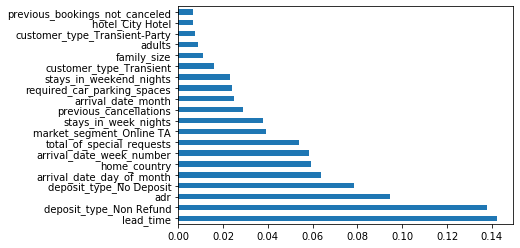

In [53]:
feat_imp = rf.feature_importances_
dataframe = pd.Series(feat_imp,
                 index=X.columns.values)
dataframe.sort_values(ascending=False)[:20].plot(kind ='barh')

### Interpreting the feature importance based on our EDA

* It seems that lead_time plays an important role in predicting whether or not a customer will cancel its booking. Indeed the higher the lead time the higher the probability that the customer will cancel, ie the higher the number of days that elapsed between the entering date of the booking and the arrival date the higher the probability to cancel.
* Also, the deposit type has an important role predicting the probability of cancellation.
* It seems that people coming from portugal are more likely to cancel. This is an important feature to predict whether or not someone will cancel.
* It seems that the higher the number of special requests, the less likely customers will cancel their reservation.
* It seems that the fact that someone has already cancelled its booking is an important predictor regarding the probability of cancellation.